Modifies the existing code from: `sindy_with_exact_derivatives.ipynb`

In [189]:
import h5py
import numpy as np
from scipy.integrate import solve_ivp
from derivative import dxdt
import matplotlib.pyplot as plt

In [190]:
# Define the Lorenz equations
def lorenz(_: float, u: np.ndarray, sigma: float, rho: float, beta: float) -> np.ndarray:
       """Returns a list containing the three functions of the Lorenz equation.

       The Lorenz equations have constant coefficients (that don't depend on t),
       but we still receive t as the first parameter because that's how the
       integrator works.
       """
       x = u[0]
       y = u[1]
       z = u[2]
       dx_dt = sigma * (y - x)
       dy_dt = x * (rho - z) - y
       dz_dt = x * y - beta * z

       return np.hstack((dx_dt, dy_dt, dz_dt))

In [191]:
# defines the constants needed for the Lorenz equations
SIGMA = 10 # rate of diffusion
RHO = 28 # Rayleigh number - defines convection properties
BETA = 8 / 3 

# defines the initial conditions of our system
t0 = 0
tmax = 100
samples = 10000 # 10,000 temporal samples
t = np.linspace(start=t0, stop=tmax, num=samples) # temporal space

u0 = np.array([-8, 8, 27]) # initial condition at t=0

# solve the lorenz system
result = solve_ivp(fun=lorenz,
                        t_span=(t0, tmax),
                        y0=u0,
                        t_eval=t,
                        args=(SIGMA, RHO, BETA))
u = result.y.T # the solution of the system through time
print(u.shape)

(10000, 3)


In [192]:
def calculate_exact_derivatives(u: np.ndarray) -> np.ndarray:
    """Calculates the exact derivatives by using the Lorenz equations.

    Since we have the equations in this scenario, we can calculate the
    exact derivatives. This is easily done by simply plugging u into the
    equations, and getting du/dt back. In a real-world scenario, we don't
    have the equations -- that's what we're trying to discover with SINDy!
    """
    n = u.shape[0]
    uprime = np.zeros_like(u)
    for i in range(n):
        uprime[i, :] = lorenz(None, u[i, :], SIGMA, RHO, BETA)

    return uprime

In [193]:
def create_library(u: np.ndarray, polynomial_order: int, use_trig: bool) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.

    For example, if our u depends on x, y, and z, and we specify
    polynomial_order=2 and use_trig=false, our terms would be:
    1, x, y, z, x^2, xy, xz, y^2, yz, z^2.
    """
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    if use_trig:
        for i in range(1, 11):
            theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

    return theta

In [194]:
def calculate_regression(theta: np.ndarray, uprime: np.ndarray, threshold: float, max_iterations: int) -> np.ndarray:
    """Finds a xi matrix that fits theta * xi = uprime, using the sequential
    thresholded least-squares algorithm, which is a regression algorithm that
    promotes sparsity.

    The authors of the SINDy paper designed this algorithm as an alternative
    to LASSO, because they found LASSO to be algorithmically unstable, and
    computationally expensive for very large data sets.
    """
    # Solve theta * xi = uprime in the least-squares sense.
    xi = np.linalg.lstsq(theta, uprime, rcond=None)[0]
    n = xi.shape[1]

    # Add sparsity.
    for _ in range(max_iterations):
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
        for j in range(n):
            big_indices = np.logical_not(small_indices[:, j])
            xi[big_indices, j] = np.linalg.lstsq(theta[:, big_indices],
                                                 uprime[:, j],
                                                 rcond=None)[0]

    return xi

(a) Assume you have the true derivatives, but they are noisy. Simulate
that by adding a Gaussian with variance 0.01, 0.1, and 0.5. Present your re-
sults in a way that shows how well the accuracy of your discovered coefficients
improve/worsen with increase in noise. Play with the maximum number of
iterations in STLSQ algorithm or with the number of basis functions.


Noise Variance: 0.01
Average Difference: 0.0000088945

Noise Variance: 0.1
Average Difference: 0.0000627417

Noise Variance: 0.5
Average Difference: 0.0002105810


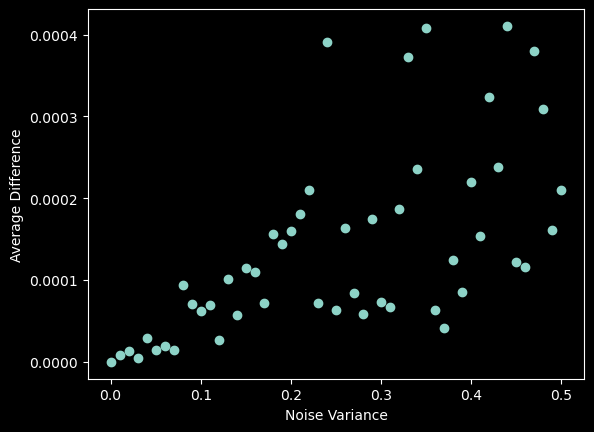

In [195]:
# Constants used in the calculation of the Theta matrix of potential terms.
POLYNOMIAL_ORDER = 2
USE_TRIG = False
# Constants used in the Sequential Thresholded Least-Squares algorithm.
THRESHOLD = 0.025
MAX_ITERATIONS = 100


exact_derivs = calculate_exact_derivatives(u) # the exact derivatives of the system
noise_variance = [0.01, 0.1, 0.5] # the gaussian noise variance to be added to the derivatives
noise_variance = np.arange(0, 0.51, 0.01)
theta = create_library(u, POLYNOMIAL_ORDER, USE_TRIG) # the Theta matrix of potential terms
exact_xi = calculate_regression(theta, exact_derivs, THRESHOLD, MAX_ITERATIONS)
avg_diff_list = []

for variance in noise_variance:
    noisy_derivs = exact_derivs + np.random.normal(0, variance, exact_derivs.shape) # the noisy derivatives of the system
    
    noisy_xi = calculate_regression(theta, noisy_derivs, THRESHOLD, MAX_ITERATIONS) # the xi matrix that fits theta * xi = uprime

    # compute difference between discovered coefficients and actual coefficients
    diff = np.abs(noisy_xi - exact_xi)
    avg_diff = np.mean(diff)
    avg_diff_list.append(avg_diff)
    if (variance == 0.01 or variance == 0.1 or variance == 0.5):
        print(f"\nNoise Variance: {variance}")
        # print("Discovered Coefficients (xi):")
        # print(noisy_xi)
        # print("Difference between discovered coefficients and actual coefficients:")
        # print(np.char.mod('%.4f', diff).astype(float))
        print(f"Average Difference: {avg_diff:.10f}")
        
plt.scatter(noise_variance, avg_diff_list)
plt.xlabel('Noise Variance');
plt.ylabel('Average Difference');

The Results show us that the accuracy of the discovered coefficients tend worsen with an increase in noise. However as we increase the number of basis functions, or the number of Iterations the accuracy of all of discovered coefficients improve, although we still see the same correlation between the increase in noise and the decrease in accuracy. Increasing the number of iterations also helps to control the spread of the resulting discovered coefficients with noise applied.

(b) Compute the derivatives using data of x(t), y(t), and z(t). Use first order
finite difference, or central difference, or any other method. Perhaps try fitting a
cubic spline using every 4 consecutive temporal samples and then computing the
derivative using the splines. Finally, report your discovered coefficients in a way
that shows how the effect of your derivative scheme reflects in your discovered
coefficients

In [196]:
def forward_difference_derivative(u: np.ndarray, t: np.ndarray) -> np.ndarray:
    """
    Estimates the time derivative of u using forward differences.
    """
    dt = t[1] - t[0] # size of the first time step
    uprime_fd = np.zeros_like(u)
    for i in range(u.shape[1]): # for each variable
        uprime_fd[:-1, i] = (u[1:, i] - u[:-1, i]) / dt # forward difference
        uprime_fd[-1, i] = (u[-1, i] - u[-2, i]) / dt # backward difference for the last point
    return uprime_fd

def central_difference_derivative(u: np.ndarray, t: np.ndarray) -> np.ndarray:
    """
    Estimates the time derivative of u using central differences
    """
    dt = t[1] - t[0]
    uprime_fd = np.zeros_like(u)
    for i in range(u.shape[1]): # for each variable
        uprime_fd[0, i] = (u[1, i] - u[0, i]) / dt # forward difference for the first point
        uprime_fd[1:-1, i] = (u[2:, i] - u[:-2, i]) / (2 * dt) # central difference
        uprime_fd[-1, i] = (u[-1, i] - u[-2, i]) / dt # backward difference for the last point
    return uprime_fd

forward_difference = forward_difference_derivative(u, t)
central_difference = central_difference_derivative(u, t)

# Run regression using finite difference derivatives.
forward_xi = calculate_regression(theta, forward_difference, THRESHOLD, MAX_ITERATIONS)
central_xi = calculate_regression(theta, central_difference, THRESHOLD, MAX_ITERATIONS)

print("Discovered Coefficients using forward finite differences:")
print(forward_xi)

diff = np.abs(forward_xi - exact_xi)
# print("Difference between discovered coefficients and actual coefficients:")
# print(np.char.mod('%.9f', diff).astype(float))

avg_diff = np.mean(diff)
print("forward finite difference vs actual coefficients")
print(f"    Average Difference: {avg_diff:.10f}")

print()
print()

print("Discovered Coefficients using central finite differences:")
print(central_xi)

diff = np.abs(central_xi - exact_xi)
# print("Difference between discovered coefficients and actual coefficients:")
# print(np.char.mod('%.9f', diff).astype(float))

avg_diff = np.mean(diff)
print("central finite difference vs actual coefficients")
print(f"    Average Difference: {avg_diff:.10f}")


Discovered Coefficients using forward finite differences:
[[ 0.         -0.19671503  0.56816771]
 [-8.09542946 26.08518467  0.        ]
 [ 9.43556075  0.79245818  0.        ]
 [ 0.          0.         -2.61566289]
 [ 0.          0.         -0.05677329]
 [ 0.          0.          0.89185088]
 [-0.0496053  -0.9175055   0.        ]
 [ 0.          0.          0.10477387]
 [ 0.         -0.09172379  0.        ]
 [ 0.          0.          0.        ]]
forward finite difference vs actual coefficients
    Average Difference: 0.2495229896


Discovered Coefficients using central finite differences:
[[ 0.          0.          0.03486737]
 [-9.98203659 27.61238813  0.        ]
 [ 9.98189458 -0.91816386  0.        ]
 [ 0.          0.         -2.66071444]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.99626213]
 [ 0.         -0.98815571  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
central finite

We can tell from the results that the forward method is a less accurate method of finding the derivatives, because the discovered coefficients are less accurate than the true coefficients. The central method is more accurate than the forward method, but still less accurate than the true coefficients. I wasn't able to implement the cubic spine method because but I would expect it be even more accurate than the central method.